In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from sklearn.linear_model import LinearRegression
import h5py
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import maxflow
from PIL import Image, ImageOps
from scipy.spatial import KDTree
from skimage.filters import threshold_otsu, try_all_threshold
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from skimage.filters import threshold_minimum, threshold_otsu
from scipy.stats import pearsonr, spearmanr, kendalltau

from tableone import TableOne

# 予後データの読み込み

In [2]:
center_name_list = ["NCC", "YCU", "UT"]

In [3]:
icgc_rep_data = pd.read_csv('./prog_data/clinical_final.csv', encoding='shift_jis')
icgc_rep_data = icgc_rep_data[~icgc_rep_data["rename_T"].isna()]

/tmp/ipykernel_236103/1114303520.py:1: DtypeWarning: Columns (0,1,2,4,5,6,8,10,11,13,14,15,19,24,25,26,27,39,40,41,42,43,44,45,46,47,52,56,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  icgc_rep_data = pd.read_csv('./prog_data/clinical_final.csv', encoding='shift_jis')


In [4]:
icgc_rep_data_2 = pd.read_table('./prog_data/TKYC_NCC_TCGA2048_k1vts839_idx_ViT_colortransformation_clinical_csv_with_number.txt', encoding='latin1')
icgc_rep_data_2= icgc_rep_data_2[~icgc_rep_data_2["rename_T"].isna()]

In [5]:
mol_subtype = pd.read_csv("./prog_data/Molecular_subtype.txt", delimiter="\t")

In [6]:
icgc_rep_data = pd.merge(
    icgc_rep_data,
    icgc_rep_data_2,
    left_on="rename_T",
    right_on="rename_T",
    how="inner",  # 共通のサンプルだけ抽出（必要に応じて "left", "outer", "right" に変更可）
    suffixes=('', '_drop')  # df2 側を "_drop" で区別
)



In [7]:
histological_type_unique = np.unique(icgc_rep_data["Major histological type (JPN)"].tolist())

In [8]:
icgc_rep_data = pd.merge(
    icgc_rep_data,
    mol_subtype,
    left_on="rename_T",
    right_on="ID",
    how="inner"  # 共通のサンプルだけ抽出（必要に応じて "left", "outer", "right" に変更可）
)

In [9]:
raw_prog_data = icgc_rep_data.copy()
raw_prog_data

,Analysis location,Sample Name,WES Mutational Signature,0;exclusion 1;adoption,Exlusion reason,rename_T,rename_N,inclusion,Cluster_class,leaf_order,...,WES_Exlusion_reason,WES_rename_T,WES_rename_N,EPIC_0;exclusion 1;adoption 2; EPIC no data.1,Lauren (1_intestinal; 2_others)_drop,Lauren (1_diffuse; 2_others)_drop,Details of PreCTx.1,Chemotherapy (All) After Surgery.1,Molecular_subtype,ID
0,RCAST,289,GC_289T-GC_289N,1.0,NaN,GC_289T,GC_289N,1.0,AFP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GC_289T
1,RCAST,299,GC_299T1-GC_299N,1.0,NaN,GC_299T1,GC_299N,1.0,Normal like,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GC_299T1
2,RCAST,306,GC_306T-GC_306N,1.0,NaN,GC_306T,GC_306N,1.0,Normal like,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GS,GC_306T
3,RCAST,307,GC_307T-GC_307N,1.0,NaN,GC_307T,GC_307N,1.0,RTK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GS,GC_307T
4,RCAST,313,GC_313T-GC_313N,1.0,NaN,GC_313T,GC_313N,1.0,Metaplasia,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GC_313T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,RCAST,GCYC_Y1_82T_WE,GCYC_Y1_82T_WE-GCYC_Y1_82N_WE,1.0,NaN,GCYC_Y1_82T_WE,GCYC_Y1_82N_WE,1.0,AFP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GCYC_Y1_82T_WE
391,RCAST,GCYC_Y1_92T_WE,GCYC_Y1_92T_WE-GCYC_Y1_92N_WE,1.0,NaN,GCYC_Y1_92T_WE,GCYC_Y1_92N_WE,1.0,RTK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GCYC_Y1_92T_WE
392,RCAST,GCYC_Y1_94T_WE,GCYC_Y1_94T_WE-GCYC_Y1_94N_WE,1.0,NaN,GCYC_Y1_94T_WE,GCYC_Y1_94N_WE,1.0,Diffuse,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GCYC_Y1_94T_WE
393,RCAST,GCYC_Y1_95T_WE,GCYC_Y1_95T_WE-GCYC_Y1_95N_WE,1.0,NaN,GCYC_Y1_95T_WE,GCYC_Y1_95N_WE,1.0,Immune,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIN,GCYC_Y1_95T_WE


In [10]:
icgc_rep_data.columns.tolist()

['Analysis location',
 'Sample Name',
 'WES            Mutational Signature',
 '0;exclusion 1;adoption',
 'Exlusion reason',
 'rename_T',
 'rename_N',
 'inclusion',
 'Cluster_class',
 'leaf_order',
 '0;exclusion 1;adoption\n2; EPIC no data',
 'rename_T.1',
 'order',
 'AJCC_UICC(8th)',
 'Tumor site',
 'Lauren (intestinal-mixed-diffuse)',
 'Lauren (1_intestinal; 2_others)',
 'Lauren (1_diffuse; 2_others)',
 'Tumor content',
 'EBV',
 'Hypermutator',
 'Mutations/Mb',
 'survival',
 'Survival days',
 'Drinking habit',
 'Smoking habit',
 'Alcohol',
 'Smoking',
 'C:G>T:A',
 'C:G>G:C',
 'C:G>A:T',
 'T:A>G:C',
 'T:A>C:G',
 'T:A>A:T',
 'SNV',
 'insersion',
 'deletion',
 'indel',
 'total',
 'Preoperative Chemotherapy (PreCTx)',
 'Details of PreCTx',
 'Effect (Histological Grade) of Preoperative Chemotherapy',
 'Postoperative Adjuvant Chemotherapy',
 'Chemotherapy (All) After Surgery',
 'Title of Pathological Diagnosis',
 'Details of Pathology',
 'Major histological type (JPN)',
 'WHO_histological_

In [15]:
icgc_rep_data = icgc_rep_data[icgc_rep_data['Number of Details of Pathology']>0]
samples_with_pathological_clone = icgc_rep_data["rename_T"].tolist()

In [16]:
path_clone_num_sample = icgc_rep_data["rename_T"]
path_clone_num_list=icgc_rep_data['Number of Details of Pathology']
path_clone_num_dict = dict(zip(path_clone_num_sample, path_clone_num_list))

In [17]:
# パスにマッチするファイル一覧（フルパス）
file_paths = []
for center_name in center_name_list:
    if center_name == "UT":
        temp_path = f"/wsi/analysis/ICGC/chief/{center_name}/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/*_patch_attention.csv"
    else:
        temp_path = f"/wsi/analysis/ICGC/chief/{center_name}/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/*_patch_attention.csv"
    temp_file_paths = glob.glob(temp_path)
    file_paths=file_paths+temp_file_paths

# ファイル名の「*」に該当する部分だけ取り出す
sample_with_chief_list = [os.path.basename(f).replace('_patch_attention.csv', '') for f in file_paths]

print(len(sample_with_chief_list))

524


In [18]:
dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/ICGC_clustering_pca80var_integrate_mag40_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
]

cluster_chief_list = []


#samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys()))&set(sample_with_chief_list))
samples_with_cluster = list(set(samples_with_cluster_all)&set(samples_with_pathological_clone)&set(sample_with_chief_list))


print(len(samples_with_cluster))    
for temp_sample in samples_with_cluster:
    path_2_clustering = f"{dir_path}/{temp_sample}"
    optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")

    
    base_path = "/data/shirasuna/work/hetero_path/ICGC_wsi_patch"
    h5_file_path = None
    
    for temp_center in center_name_list:
        temp_path = os.path.join(base_path, f"patched_{temp_center}_mag40",  "patches", f"{temp_sample}.h5")
        if os.path.exists(temp_path):
            h5_file_path = temp_path
            break
    
    if h5_file_path is None:
        raise FileNotFoundError(f"{temp_sample}.h5 was not found in any of the specified directories.")
    
    h5_wsi = h5py.File(h5_file_path, 'r')

    EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/ICGC_encode_with_mask/features_{temp_center}/{temp_sample}"
    epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
    #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")

    estimated_clone_num= len(np.unique(optimized_state))

    # chief
    if temp_center == "UT":
        chief_result_path = f"/wsi/analysis/ICGC/chief/{temp_center}/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    else:
        chief_result_path = f"/wsi/analysis/ICGC/chief/{temp_center}/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    chief_result_df = pd.read_csv(chief_result_path)

    
    # 4つの近傍のattension valueの平均で各座標のattension valueを定義
    x_coord_chief = chief_result_df["x_coord"].tolist()
    y_coord_chief = chief_result_df["y_coord"].tolist()
    attension_chief_list = chief_result_df["attention_value"].tolist()
    
    coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
    attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

    # --- KDTree を使用した最近傍探索 ---
    kdtree = KDTree(coord_chief)
    
    # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
    #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
    #    k=1 は最も近い1点を探すことを意味します。
    distances, nearest_indices = kdtree.query(epi_coords, k=4)
    
    # nearest_indices は、wsi_patch_coords の各点に対応する、
    # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
    # shape=(M,) 例: (42849,)
    
    # 3. 得られたインデックスを使って、対応する attention 値を取得
    #    attension_chief_array から、nearest_indices を使って値を取り出します。

    wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
    ###平均のattension valueが4以上のclusterのみカウント

    mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
    

    patch_num = 0
    for cluster in np.unique(optimized_state):
        mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
        cluster_chief_list.append(mean_attension)


cluster_chief_array = np.array(cluster_chief_list)
#min_thresh = threshold_minimum(cluster_chief_array)
otsu_thresh = threshold_otsu(cluster_chief_array)

# 分割
low_attention = cluster_chief_array[cluster_chief_array <= otsu_thresh]
high_attention = cluster_chief_array[cluster_chief_array > otsu_thresh]


print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")

292
Otsu threshold: 3.9234131268942005
Low attention cluster count: 659
High attention cluster count: 1513


Otsu threshold: 3.9234131268942005
Low attention cluster count: 659
High attention cluster count: 1513


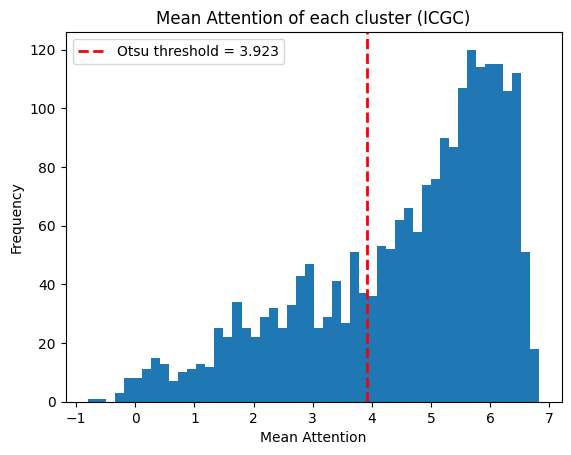

In [19]:
print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")



plt.hist(cluster_chief_list, bins=50)
plt.xlabel("Mean Attention")
plt.ylabel("Frequency")
plt.title("Mean Attention of each cluster (ICGC)")

# ここで赤い縦線を追加
plt.axvline(x=otsu_thresh, color='red', linestyle='--', linewidth=2, label=f'Otsu threshold = {otsu_thresh:.3f}')
plt.legend()

plt.show()

In [20]:
samples_with_cluster = list(set(samples_with_cluster_all)&set(samples_with_pathological_clone)&set(sample_with_chief_list))
len(samples_with_cluster)

292

In [21]:
# パスにマッチするファイル一覧（フルパス）
file_paths = []
center_name_list=["NCC", "YCU", "UT"]
for center_name in center_name_list:
    if center_name == "UT":
        temp_path = f"/wsi/analysis/ICGC/chief/{center_name}/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/*_patch_attention.csv"
    else:
        temp_path = f"/wsi/analysis/ICGC/chief/{center_name}/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/*_patch_attention.csv"
    temp_file_paths = glob.glob(temp_path)
    file_paths=file_paths+temp_file_paths

# ファイル名の「*」に該当する部分だけ取り出す
sample_with_chief_list = [os.path.basename(f).replace('_patch_attention.csv', '') for f in file_paths]

print(len(sample_with_chief_list))

524


In [22]:
tum_threshold_value_in_chief=otsu_thresh


dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/ICGC_clustering_pca80var_integrate_mag40_init20/"


samples_with_pathological_clone = icgc_rep_data["rename_T"].tolist()

samples_with_cluster = list(set(samples_with_cluster_all)&set(samples_with_pathological_clone)&set(sample_with_chief_list))

print(len(samples_with_cluster))



sample_name_list = []
patch_num_list = []
estimated_clone_num_list = []
corr_estimated_clone_num_list = []
pathological_clone_num_list = []


for temp_sample in samples_with_cluster:
    path_2_clustering = f"{dir_path}/{temp_sample}"
    optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")

    for temp_center in center_name_list:
        temp_path = f"/data/shirasuna/work/hetero_path/ICGC_wsi_patch/patched_{temp_center}_mag40/patches/{temp_sample}.h5"
        if os.path.exists(temp_path):
            h5_file_path = temp_path
            break
    h5_wsi = h5py.File(h5_file_path, 'r')

    EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/ICGC_encode_with_mask/features_{temp_center}/{temp_sample}"
    epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
    #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")

    estimated_clone_num= len(np.unique(optimized_state))

    # chief
    if temp_center == "UT":
        chief_result_path = f"/wsi/analysis/ICGC/chief/{temp_center}/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    else:
        chief_result_path = f"/wsi/analysis/ICGC/chief/{temp_center}/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    chief_result_df = pd.read_csv(chief_result_path)
    
    # 4つの近傍のattension valueの平均で各座標のattension valueを定義
    x_coord_chief = chief_result_df["x_coord"].tolist()
    y_coord_chief = chief_result_df["y_coord"].tolist()
    attension_chief_list = chief_result_df["attention_value"].tolist()
    
    coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
    attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

    # --- KDTree を使用した最近傍探索 ---
    kdtree = KDTree(coord_chief)
        
    # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
    #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
    #    k=1 は最も近い1点を探すことを意味します。
    distances, nearest_indices = kdtree.query(epi_coords, k=4)
    
    # nearest_indices は、wsi_patch_coords の各点に対応する、
    # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
    # shape=(M,) 例: (42849,)
    
    # 3. 得られたインデックスを使って、対応する attention 値を取得
    #    attension_chief_array から、nearest_indices を使って値を取り出します。

    wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
    
    ###平均のattension valueが4以上のclusterのみカウント

    mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)

    estimated_clone_num=0
    #estimated_clone_num=len(np.unique(optimized_state))
    patch_num = len(optimized_state)

 
    patch_num = 0
    for cluster in np.unique(optimized_state):
        mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
        if mean_attension > tum_threshold_value_in_chief:
            estimated_clone_num+=1
            patch_num+=np.sum(optimized_state==cluster)



    # 例: create_knn_graph の出力を使用
    
    sample_name_list.append(temp_sample)
    patch_num_list.append(patch_num)
    estimated_clone_num_list.append(estimated_clone_num)
    pathological_clone_num_list.append(path_clone_num_dict[temp_sample])
    
    corr_estimated_clone_num=estimated_clone_num*(patch_num)**(1/2)

    corr_estimated_clone_num_list.append(corr_estimated_clone_num)


patch_25 = np.percentile(patch_num_list, 5)
patch_75 = np.percentile(patch_num_list, 95)

filtered_sample_name_list=[]
filtered_patch_num_list = []
filtered_estimated_clone_num_list = []
filtered_pathological_clone_num_list = []
filtered_corr_estimated_clone_num_list = []


for i in range(len(sample_name_list)):
    if patch_25<patch_num_list[i] and patch_75>patch_num_list[i]:
        filtered_sample_name_list.append(sample_name_list[i])
        filtered_patch_num_list.append(patch_num_list[i])
        filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
        filtered_pathological_clone_num_list.append(pathological_clone_num_list[i])
        filtered_corr_estimated_clone_num_list.append(corr_estimated_clone_num_list[i])



292


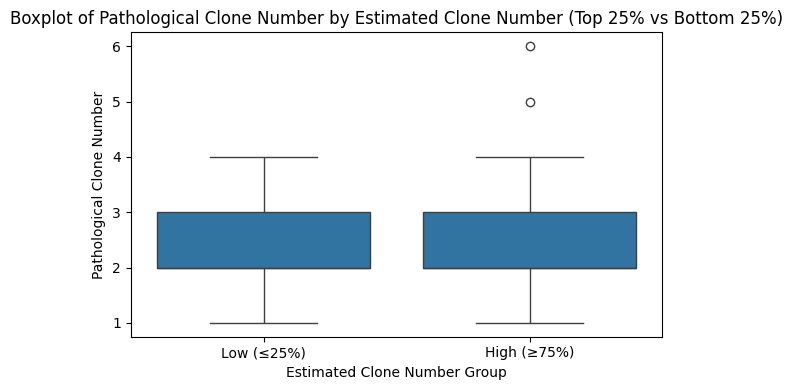

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# NumPy配列に変換（もしリストのままなら）
estimated = np.array(estimated_clone_num_list)
pathological = np.array(pathological_clone_num_list)

# 四分位点を計算
q25 = np.percentile(estimated, 25)
q75 = np.percentile(estimated, 75)

# 下位25%、上位25%でグループ分け
group_low  = pathological[estimated <= q25]
group_high = pathological[estimated >= q75]

# 可視化用データフレーム作成
df = pd.DataFrame({
    'Group': ['Low (≤25%)']  * len(group_low) + ['High (≥75%)'] * len(group_high),
    'Pathological Clone Number': np.concatenate([group_low, group_high])
})

# 📊 ボックスプロット描画
plt.figure(figsize=(6, 4))
sns.boxplot(x='Group', y='Pathological Clone Number', data=df)
plt.title("Boxplot of Pathological Clone Number by Estimated Clone Number (Top 25% vs Bottom 25%)")
plt.ylabel("Pathological Clone Number")
plt.xlabel("Estimated Clone Number Group")
plt.tight_layout()
plt.show()


In [25]:
df

,Group,Pathological Clone Number
0,Low (≤25%),2.0
1,Low (≤25%),3.0
2,Low (≤25%),2.0
3,Low (≤25%),3.0
4,Low (≤25%),1.0
...,...,...
170,High (≥75%),3.0
171,High (≥75%),3.0
172,High (≥75%),3.0
173,High (≥75%),2.0


In [26]:
# NumPy配列に変換（もしリストのままなら）
estimated = np.array(estimated_clone_num_list)
pathological = np.array(pathological_clone_num_list)

# 四分位点を計算
q25 = np.percentile(estimated, 25)
q50 = np.percentile(estimated, 50)  # 中央値
q75 = np.percentile(estimated, 75)

# 四分位ごとにグループ分け
def assign_quartile_group(val):
    if val <= q25:
        return "Q1 (0–25%)"
    elif val <= q50:
        return "Q2 (25–50%)"
    elif val <= q75:
        return "Q3 (50–75%)"
    else:
        return "Q4 (75–100%)"

groups = [assign_quartile_group(v) for v in estimated]

# DataFrame作成
df = pd.DataFrame({
    'Group': groups,
    'Pathological Clone Number': pathological
})

# 各四分位グループの平均を計算し、順序を揃える
group_order = ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]
mean_values = df.groupby('Group')['Pathological Clone Number'].mean().reindex(group_order)

print("各四分位グループのPathological Clone Numberの平均:")
print(mean_values)

各四分位グループのPathological Clone Numberの平均:
Group
Q1 (0–25%)      2.146341
Q2 (25–50%)     2.382022
Q3 (50–75%)     2.326531
Q4 (75–100%)    2.388889
Name: Pathological Clone Number, dtype: float64


In [27]:
# 四分位ごとの平均を計算
mean_values = df.groupby('Group')['Pathological Clone Number'].mean().reindex([
    "Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"
])

print("各四分位グループのPathological Clone Numberの平均:")
print(mean_values)
# グループ順序に対応した数値を割り当て（Q1=1, ..., Q4=4）
group_order = ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]
group_numeric = [1, 2, 3, 4]

# 平均値を計算（Q1〜Q4順に並べる）
mean_values = df.groupby('Group')['Pathological Clone Number'].mean().reindex(group_order)

print("各四分位グループのPathological Clone Numberの平均:")
print(mean_values)

# 🧪 Kendall's tauで順位相関を検定
tau, p_value = kendalltau(group_numeric, mean_values.values)

print(f"\n四分位グループ順と平均Pathological Clone NumberのKendall's tau検定結果:")
print(f"Kendall's tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

各四分位グループのPathological Clone Numberの平均:
Group
Q1 (0–25%)      2.146341
Q2 (25–50%)     2.382022
Q3 (50–75%)     2.326531
Q4 (75–100%)    2.388889
Name: Pathological Clone Number, dtype: float64
各四分位グループのPathological Clone Numberの平均:
Group
Q1 (0–25%)      2.146341
Q2 (25–50%)     2.382022
Q3 (50–75%)     2.326531
Q4 (75–100%)    2.388889
Name: Pathological Clone Number, dtype: float64

四分位グループ順と平均Pathological Clone NumberのKendall's tau検定結果:
Kendall's tau: 0.6667
p-value: 0.3333


各グループのEstimated Clone Numberの平均:
Group
1.0     657.229962
2.0     994.567130
3.0    1064.175564
4.0     621.221735
5.0     622.703960
6.0    1073.267643
Name: Estimated Clone Number, dtype: float64

Group順と平均Estimated Clone NumberのKendall's tau検定結果:
Kendall's tau: 0.2000
p-value: 0.7194


ValueError: List of boxplot statistics and `positions` values must have same the length

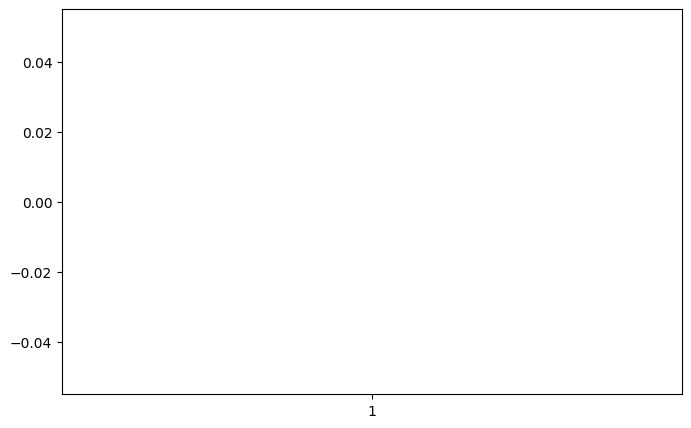

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

# NumPy配列に変換
estimated = np.array(corr_estimated_clone_num_list)
pathological = np.array(pathological_clone_num_list)

# DataFrame作成
df = pd.DataFrame({
    'Estimated Clone Number': estimated,
    'Pathological Clone Number': pathological
})

# グループラベルとしてそのまま使用（1, 2, 3）
df['Group'] = df['Pathological Clone Number'].astype(str)  # カテゴリ化（文字列にすることで順番保持）

# 各グループごとの Estimated の平均を計算
mean_values = df.groupby('Group')['Estimated Clone Number'].mean()

# グループ番号と対応する平均値をリストに変換
group_numeric = [int(float(g)) for g in mean_values.index]  # '1.0' → 1
mean_values_list = mean_values.values

# 平均値表示
print("各グループのEstimated Clone Numberの平均:")
print(mean_values)

# 🧪 Kendall's tau 検定
tau, p_value = kendalltau(group_numeric, mean_values_list)

print(f"\nGroup順と平均Estimated Clone NumberのKendall's tau検定結果:")
print(f"Kendall's tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

# 📊 Boxplot 描画
plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='Estimated Clone Number', data=df, order=['1', '2', '3'])
plt.title("Boxplot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()

# 🎻 Violinplot 描画
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='Group',
    y='Estimated Clone Number',
    data=df,
    order=['1', '2', '3'],
    inner='box',
    cut=0
)
plt.title("Violin Plot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()


各グループのEstimated Clone Numberの平均:
Group
1.0    4.137255
2.0    5.236220
3.0    5.831579
4.0    3.846154
5.0    4.750000
6.0    7.000000
Name: Estimated Clone Number, dtype: float64

Group順と平均Estimated Clone NumberのKendall's tau検定結果:
Kendall's tau: 0.3333
p-value: 0.4694
Pearson correlation: 0.4990, p-value: 0.3136
Spearman correlation: 0.3714, p-value: 0.4685
Kendall's tau: 0.3333, p-value: 0.4694

Group順と平均Estimated Clone NumberのKendall's tau検定結果:
Kendall's tau: 0.3333
p-value: 0.4694


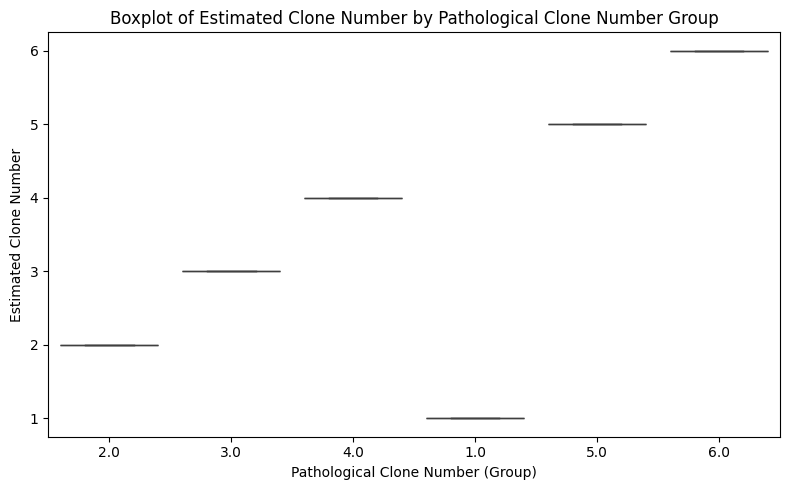

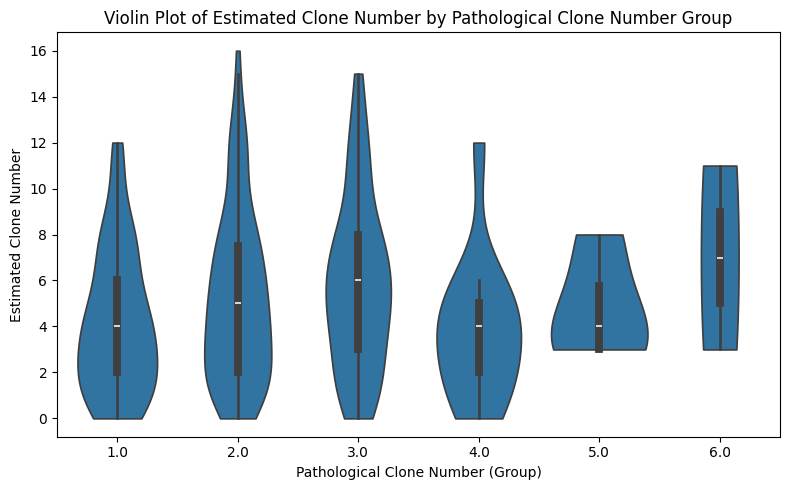

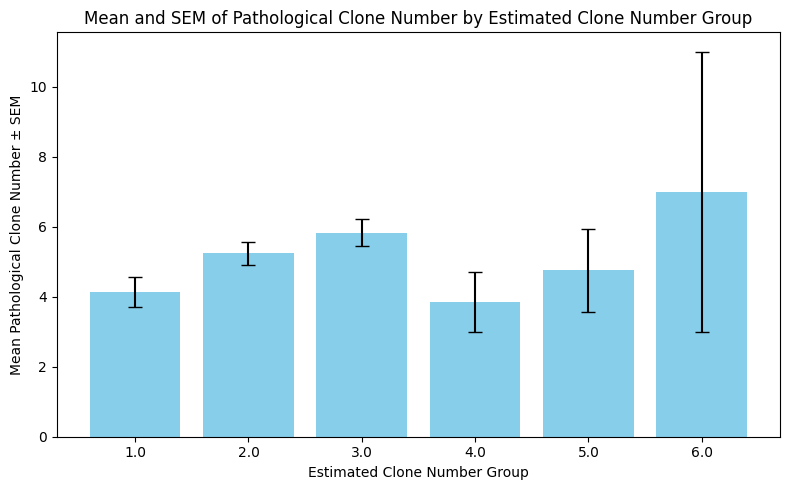

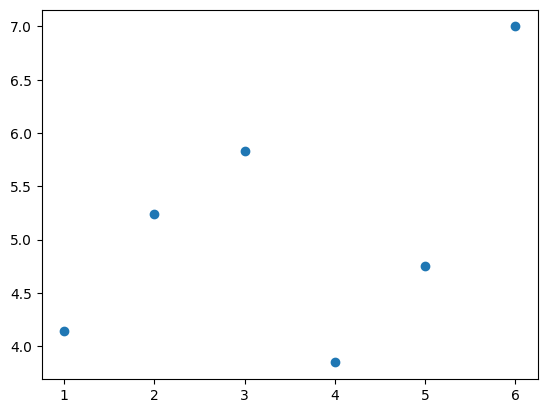

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

# NumPy配列に変換
estimated = np.array(estimated_clone_num_list)
pathological = np.array(pathological_clone_num_list)

# DataFrame作成
df = pd.DataFrame({
    'Estimated Clone Number': estimated,
    'Pathological Clone Number': pathological
})

# グループラベルとしてそのまま使用（1, 2, 3）
df['Group'] = df['Pathological Clone Number'].astype(str)  # カテゴリ化（文字列にすることで順番保持）

# 各グループごとの Estimated の平均を計算
mean_values = df.groupby('Group')['Estimated Clone Number'].mean()

# グループ番号と対応する平均値をリストに変換
group_numeric = [int(float(g)) for g in mean_values.index]  # '1.0' → 1
mean_values_list = mean_values.values

# 平均値表示
print("各グループのEstimated Clone Numberの平均:")
print(mean_values)

# 🧪 Kendall's tau 検定
tau, p_value = kendalltau(group_numeric, mean_values_list)

print(f"\nGroup順と平均Estimated Clone NumberのKendall's tau検定結果:")
print(f"Kendall's tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# スピアマン順位相関
spearman_corr, spearman_p = spearmanr(group_numeric, mean_values_list)
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# ケンドール順位相関
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)
print(f"Kendall's tau: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

print(f"\nGroup順と平均Estimated Clone NumberのKendall's tau検定結果:")
print(f"Kendall's tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

# 📊 Boxplot 描画
plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='Pathological Clone Number', data=df)
plt.title("Boxplot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()

group_order = sorted(df['Group'].unique(), key=lambda x: int(float(x)))

# 🎻 Violinplot 描画
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='Group',
    y='Estimated Clone Number',
    data=df,
    order=group_order,
    inner='box',
    cut=0
)
plt.title("Violin Plot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()

# 各グループごとの平均と標準誤差を計算
group_stats = df.groupby('Group')['Estimated Clone Number'].agg(['mean', "sem"]).reindex(group_order)

# プロット
plt.figure(figsize=(8, 5))
plt.bar(group_stats.index, group_stats['mean'], yerr=group_stats['sem'], capsize=5, color='skyblue')
plt.xlabel('Estimated Clone Number Group')
plt.ylabel('Mean Pathological Clone Number ± SEM')
plt.title('Mean and SEM of Pathological Clone Number by Estimated Clone Number Group')
plt.tight_layout()
plt.show()

plt.scatter(group_numeric, mean_values_list)

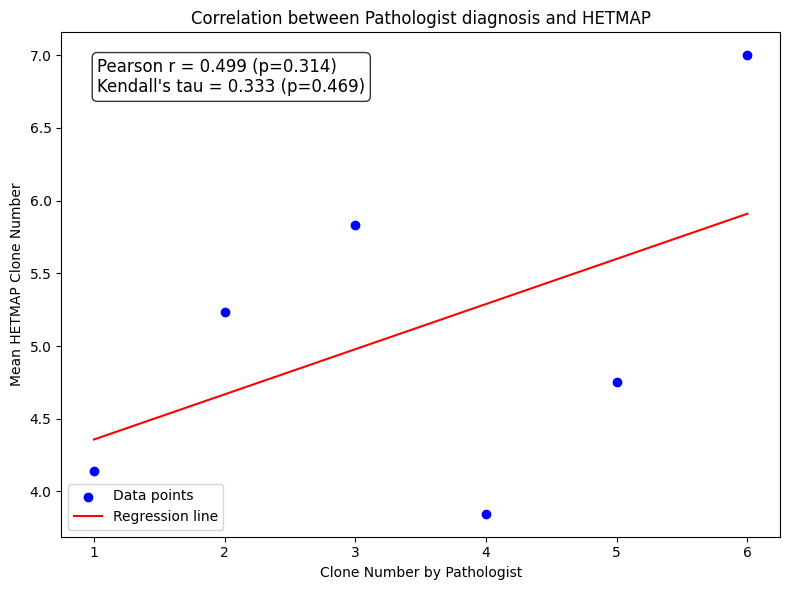

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.linear_model import LinearRegression

# 散布図作成
plt.figure(figsize=(8, 6))
plt.scatter(group_numeric, mean_values_list, color='blue', label='Data points')

# 線形回帰モデル作成
X = np.array(group_numeric).reshape(-1, 1)
y = np.array(mean_values_list)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 回帰直線描画
plt.plot(group_numeric, y_pred, color='red', label='Regression line')

# 相関係数計算
pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)

# テキスト表示（プロット内に相関係数を表示）
textstr = (
    f"Pearson r = {pearson_corr:.3f} (p={pearson_p:.3f})\n"
    f"Kendall's tau = {kendall_corr:.3f} (p={kendall_p:.3f})"
)
plt.gca().text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 軸ラベル設定
plt.xlabel('Clone Number by Pathologist')
plt.ylabel('Mean HETMAP Clone Number')
plt.title('Correlation between Pathologist diagnosis and HETMAP')
plt.legend()
plt.tight_layout()
plt.show()


各グループのEstimated Clone Numberの平均:
Group
0     2.142857
1     2.142857
10    2.500000
11    2.615385
12    2.300000
13    2.600000
14    2.500000
15    2.666667
16    2.000000
2     2.151515
3     2.520000
4     2.166667
5     2.535714
6     2.357143
7     2.285714
8     2.280000
9     2.222222
Name: Pathological Clone Number, dtype: float64

Group順と平均Estimated Clone NumberのKendall's tau検定結果:
Kendall's tau: 0.3556
p-value: 0.0476
Pearson correlation: 0.3688, p-value: 0.1452
Spearman correlation: 0.4110, p-value: 0.1012
Kendall's tau: 0.3556, p-value: 0.0476


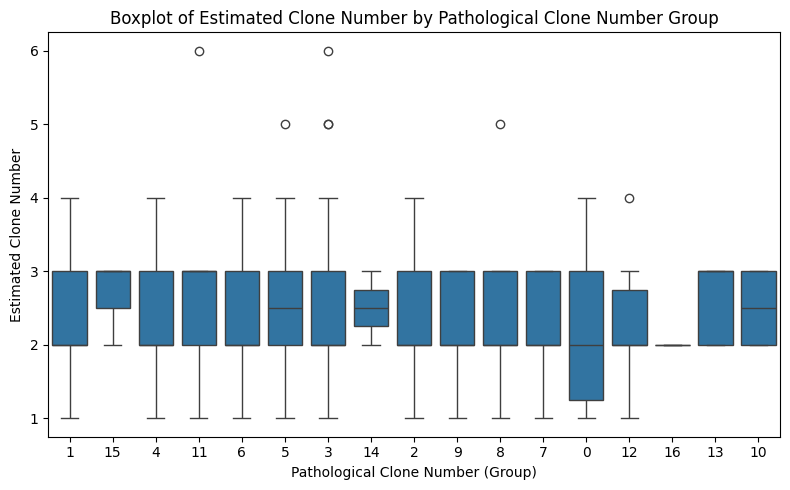

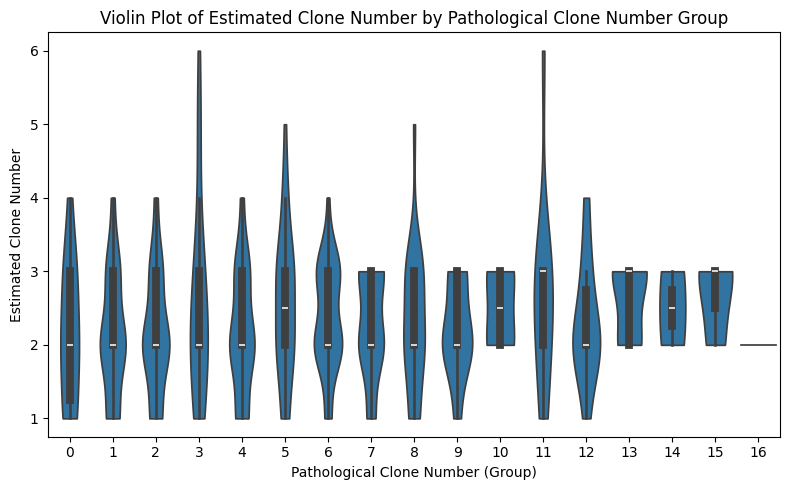

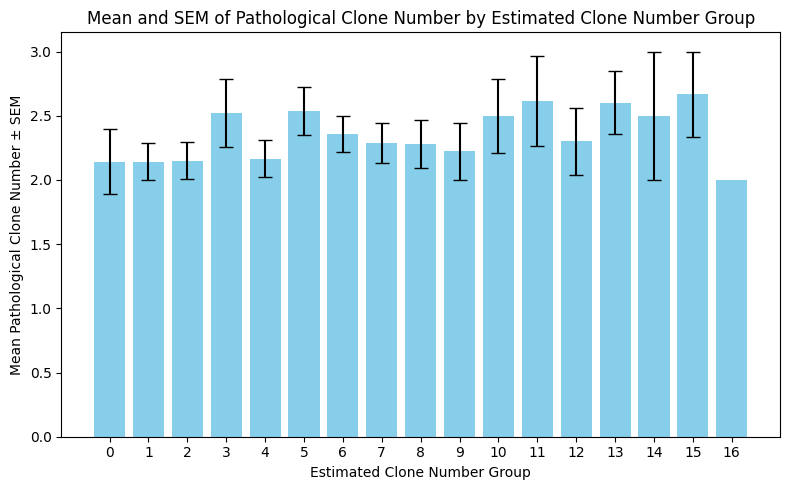

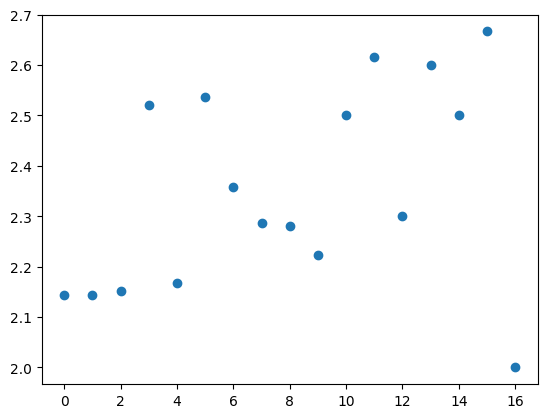

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

# NumPy配列に変換
estimated = np.array(estimated_clone_num_list)
pathological = np.array(pathological_clone_num_list)

# DataFrame作成
df = pd.DataFrame({
    'Estimated Clone Number': estimated,
    'Pathological Clone Number': pathological
})

# グループラベルとしてそのまま使用（1, 2, 3）
df['Group'] = df['Estimated Clone Number'].astype(str)  # カテゴリ化（文字列にすることで順番保持）

# 各グループごとの Estimated の平均を計算
mean_values = df.groupby('Group')['Pathological Clone Number'].mean()

# グループ番号と対応する平均値をリストに変換
group_numeric = [int(float(g)) for g in mean_values.index]  # '1.0' → 1
mean_values_list = mean_values.values

# 平均値表示
print("各グループのEstimated Clone Numberの平均:")
print(mean_values)

# 🧪 Kendall's tau 検定
tau, p_value = kendalltau(group_numeric, mean_values_list)

print(f"\nGroup順と平均Estimated Clone NumberのKendall's tau検定結果:")
print(f"Kendall's tau: {tau:.4f}")
print(f"p-value: {p_value:.4f}")

pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# スピアマン順位相関
spearman_corr, spearman_p = spearmanr(group_numeric, mean_values_list)
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# ケンドール順位相関
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)
print(f"Kendall's tau: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

# 📊 Boxplot 描画
plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='Pathological Clone Number', data=df)
plt.title("Boxplot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()

group_order = sorted(df['Group'].unique(), key=lambda x: int(float(x)))

# 🎻 Violinplot 描画
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='Group',
    y='Pathological Clone Number',
    data=df,
    order=group_order,
    inner='box',
    cut=0
)
plt.title("Violin Plot of Estimated Clone Number by Pathological Clone Number Group")
plt.xlabel("Pathological Clone Number (Group)")
plt.ylabel("Estimated Clone Number")
plt.tight_layout()
plt.show()

# 各グループごとの平均と標準誤差を計算
group_stats = df.groupby('Group')['Pathological Clone Number'].agg(['mean', "sem"]).reindex(group_order)

# プロット
plt.figure(figsize=(8, 5))
plt.bar(group_stats.index, group_stats['mean'], yerr=group_stats['sem'], capsize=5, color='skyblue')
plt.xlabel('Estimated Clone Number Group')
plt.ylabel('Mean Pathological Clone Number ± SEM')
plt.title('Mean and SEM of Pathological Clone Number by Estimated Clone Number Group')
plt.tight_layout()
plt.show()

plt.scatter(group_numeric, mean_values_list)


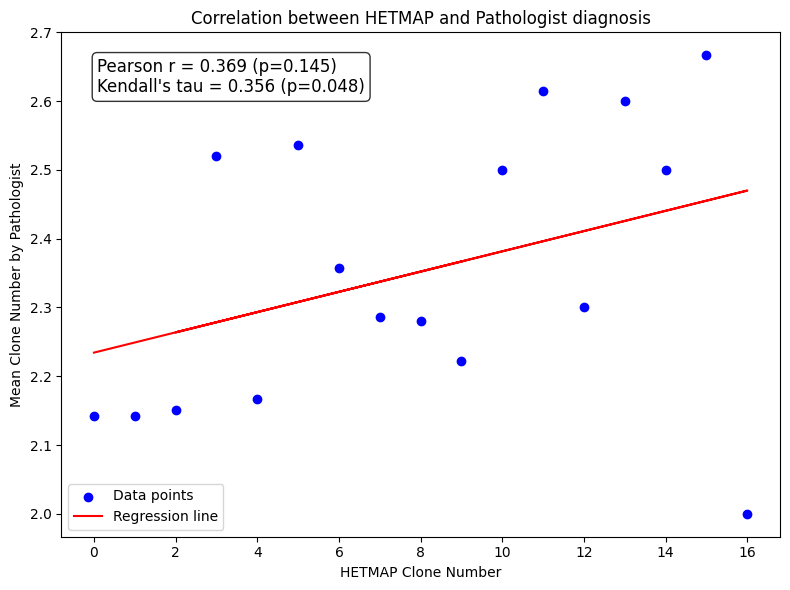

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.linear_model import LinearRegression

# 散布図作成
plt.figure(figsize=(8, 6))
plt.scatter(group_numeric, mean_values_list, color='blue', label='Data points')

# 線形回帰モデル作成
X = np.array(group_numeric).reshape(-1, 1)
y = np.array(mean_values_list)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 回帰直線描画
plt.plot(group_numeric, y_pred, color='red', label='Regression line')

# 相関係数計算
pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)

# テキスト表示（プロット内に相関係数を表示）
textstr = (
    f"Pearson r = {pearson_corr:.3f} (p={pearson_p:.3f})\n"
    f"Kendall's tau = {kendall_corr:.3f} (p={kendall_p:.3f})"
)
plt.gca().text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


# 軸ラベル設定
plt.xlabel('HETMAP Clone Number')
plt.ylabel('Mean Clone Number by Pathologist')
plt.title('Correlation between HETMAP and Pathologist diagnosis')
plt.legend()
plt.tight_layout()
plt.show()


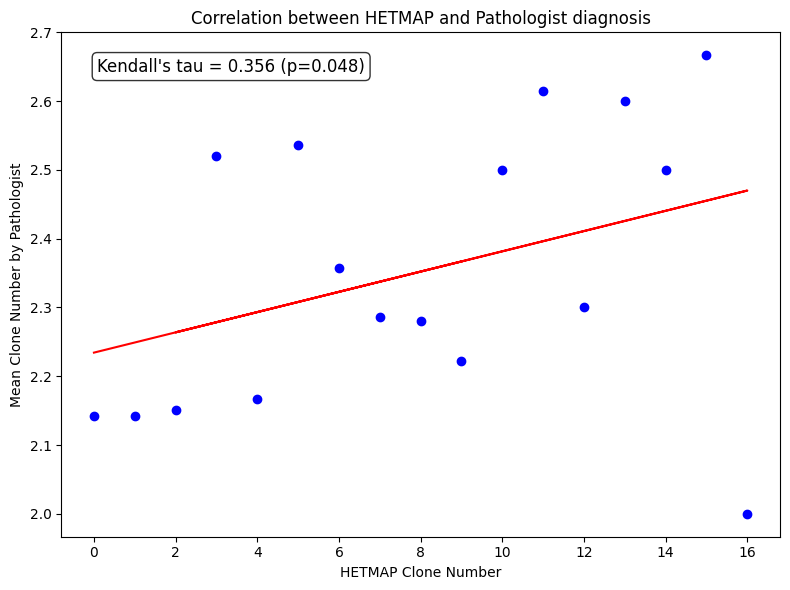

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.linear_model import LinearRegression

# 散布図作成
plt.figure(figsize=(8, 6))
plt.scatter(group_numeric, mean_values_list, color='blue', label='Data points')

# 線形回帰モデル作成
X = np.array(group_numeric).reshape(-1, 1)
y = np.array(mean_values_list)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 回帰直線描画
plt.plot(group_numeric, y_pred, color='red', label='Regression line')

# 相関係数計算
pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)

# テキスト表示（プロット内に相関係数を表示）
textstr = (
    f"Kendall's tau = {kendall_corr:.3f} (p={kendall_p:.3f})"
)
plt.gca().text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


# 軸ラベル設定
plt.xlabel('HETMAP Clone Number')
plt.ylabel('Mean Clone Number by Pathologist')
plt.title('Correlation between HETMAP and Pathologist diagnosis')
plt.tight_layout()
plt.show()


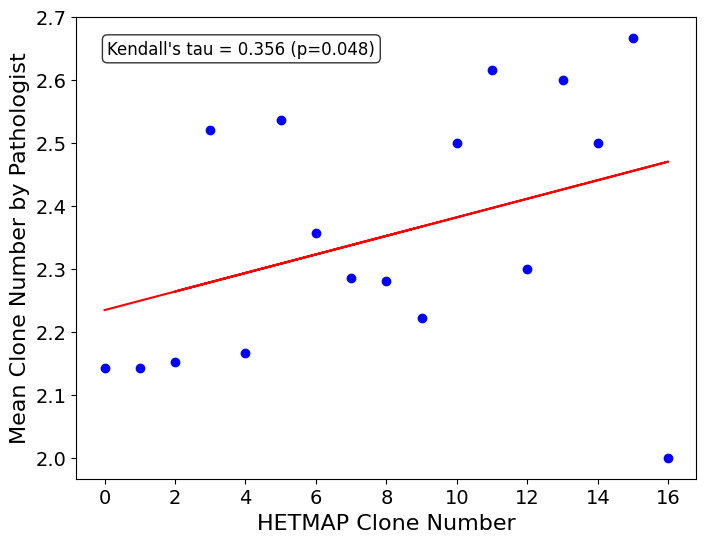

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(group_numeric, mean_values_list, color='blue', label='Data points')

# 線形回帰モデル作成
X = np.array(group_numeric).reshape(-1, 1)
y = np.array(mean_values_list)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 回帰直線描画
plt.plot(group_numeric, y_pred, color='red', label='Regression line')

# 相関係数計算
pearson_corr, pearson_p = pearsonr(group_numeric, mean_values_list)
kendall_corr, kendall_p = kendalltau(group_numeric, mean_values_list)

# テキスト表示（プロット内に相関係数を表示）
textstr = (
    f"Kendall's tau = {kendall_corr:.3f} (p={kendall_p:.3f})"
)
plt.gca().text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.xlabel('HETMAP Clone Number', fontsize=16)
plt.ylabel('Mean Clone Number by Pathologist', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.title('Correlation between HETMAP and Pathologist diagnosis', fontsize=18)
#plt.legend(fontsize=14)  # 凡例がある場合
plt.show()